In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer

In [60]:
rst = pd.read_excel('data/ERR.xlsx', sheet_name='Restaurants')
rev = pd.read_excel('data/ERR.xlsx', sheet_name='Reviews')
# retain the resturants that both in the rst and also the review data

In [61]:
# data preprocessing
rev.drop_duplicates(inplace = True)
# adjust the restaurant name format
rst['Restaurant Name'] = rst['Restaurant Name'].str.strip()
rev['Restaurant Name'] = rev['Restaurant Name'].str.strip()
rst['Brief Description'] = rst['Brief Description'].str.strip()

rev = rev.replace("Clare's Korner", "Claire's Korner")

df = pd.merge(rst, rev, on='Restaurant Name', how = 'inner')
print(df.isnull().sum()/len(df))
# correct the format
df.loc[df['Marital Status'].str.startswith('S', na=False), 'Marital Status'] = 'Single'
df.loc[df['Marital Status'].str.startswith('W', na=False), 'Marital Status'] = 'Widow'

# missingness imputation
df['Weight (lb)'] = df['Weight (lb)'].fillna(method='bfill', axis=0)
df['Height (cm)'] = df['Height (cm)'].fillna(method='bfill', axis=0)
df['Marital Status'] = df['Marital Status'].fillna(df['Marital Status'].mode()[0])
df['Has Children?'] = df['Has Children?'].fillna(df['Has Children?'].mode()[0])
# drop vegetarian? term
df.drop(columns=['Vegetarian?'], inplace=True)

Restaurant Name                0.000000
Cuisine                        0.000000
Latitude                       0.000000
Longitude                      0.000000
Average Cost                   0.000000
Open After 8pm?                0.000000
Brief Description              0.000000
Reviewer Name                  0.000000
Rating                         0.000000
Review Text                    0.383165
Date of Review                 0.000000
Birth Year                     0.001347
Marital Status                 0.023569
Has Children?                  0.025589
Vegetarian?                    0.938047
Weight (lb)                    0.065320
Height (cm)                    0.036364
Average Amount Spent           0.000673
Preferred Mode of Transport    0.002694
Northwestern Student?          0.000000
dtype: float64


/var/folders/s5/gzgpx4yd20bccw30dhctwcp40000gn/T/ipykernel_2855/3591909208.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Weight (lb)'] = df['Weight (lb)'].fillna(method='bfill', axis=0)
/var/folders/s5/gzgpx4yd20bccw30dhctwcp40000gn/T/ipykernel_2855/3591909208.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Height (cm)'] = df['Height (cm)'].fillna(method='bfill', axis=0)


In [62]:
df.isnull().sum()

Restaurant Name                  0
Cuisine                          0
Latitude                         0
Longitude                        0
Average Cost                     0
Open After 8pm?                  0
Brief Description                0
Reviewer Name                    0
Rating                           0
Review Text                    569
Date of Review                   0
Birth Year                       2
Marital Status                   0
Has Children?                    0
Weight (lb)                      0
Height (cm)                      0
Average Amount Spent             1
Preferred Mode of Transport      4
Northwestern Student?            0
dtype: int64

Question1: Use the demographic data in 'Reviews.csv' to create a unique user feature vector for each reviewer, including numeric representations of all demographic attributes in the data, including but not limited to 'Has Children?', 'Weight (lb)', 'Preferred Mode of Transport', etc. Apply one-hot encoding for categorical variables. Ensure each vector is unique to an individual reviewer, by avoiding double counting. Many reviewers have submitted reviews for multiple restaurants, so you do not want to count these people twice when making these vectors. Report the total number of unique user vectors created and the dimensionality of each vector.

In [63]:
# demographic data
demographic_cols = [
    'Reviewer Name', 'Birth Year', 'Marital Status', 'Has Children?',
    'Weight (lb)', 'Height (cm)', 'Average Amount Spent',
    'Preferred Mode of Transport', 'Northwestern Student?'
]
total_cols = demographic_cols
# Remove spaces from 'Reviewer Name' to avoid duplicates due to spaces
df_temp = df[total_cols].copy()
df_temp['Reviewer Name'] = df_temp['Reviewer Name'].str.replace(" ", "")
unique_users = df_temp.drop_duplicates(subset='Reviewer Name')
# Recover the original 'Reviewer Name' without spaces removed
unique_users['Reviewer Name'] = df['Reviewer Name'].loc[unique_users.index]
# One-hot encode categorical variables
categorical_cols = [
    'Marital Status', 'Has Children?', 'Average Amount Spent',
    'Preferred Mode of Transport', 'Northwestern Student?'
]
user_features_encoded = pd.get_dummies(unique_users, columns=categorical_cols)
print(user_features_encoded)
# Drop Reviewer Name to get the final feature matrix
feature_matrix = user_features_encoded.drop(columns='Reviewer Name')

# Report number of users and vector dimensionality
num_users = feature_matrix.shape[0]
vector_dim = feature_matrix.shape[1]

num_users, vector_dim
# print(user_features_encoded['Reviewer Name'].values) # 'Dan B', 'A B', 'Abigail']


         Reviewer Name  Birth Year  Weight (lb)  Height (cm)  \
0           Arek Gazda      1967.0        120.0        161.0   
1                  Ben      1980.0        154.0        178.0   
2         Charles Stop      1991.0        178.0        187.0   
3         Dennis Folse      1987.0        233.0        172.0   
4              Derek B      1956.0        131.0        123.0   
...                ...         ...          ...          ...   
1479    Annie Peterson      1979.0        240.0        187.0   
1481     Melanie Riley      1991.0        150.0        161.0   
1482      Gabriel Levy      1960.0        170.0        178.0   
1483  Walter Wilkerson      1981.0        180.0        182.0   
1484     Kelsey Tustin      1989.0        270.0        170.0   

      Marital Status_Married  Marital Status_Single  Marital Status_Widow  \
0                      False                  False                  True   
1                       True                  False                 False   


/var/folders/s5/gzgpx4yd20bccw30dhctwcp40000gn/T/ipykernel_2855/1707454422.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_users['Reviewer Name'] = df['Reviewer Name'].loc[unique_users.index]


(1086, 16)

In [64]:
feature_matrix.isnull().sum()

Birth Year                                    2
Weight (lb)                                   0
Height (cm)                                   0
Marital Status_Married                        0
Marital Status_Single                         0
Marital Status_Widow                          0
Has Children?_No                              0
Has Children?_Yes                             0
Average Amount Spent_High                     0
Average Amount Spent_Low                      0
Average Amount Spent_Medium                   0
Preferred Mode of Transport_Car Owner         0
Preferred Mode of Transport_On Foot           0
Preferred Mode of Transport_Public Transit    0
Northwestern Student?_No                      0
Northwestern Student?_Yes                     0
dtype: int64

In [65]:
# imputation for the weight and height use the mode
user_features_encoded['Weight (lb)'] = user_features_encoded['Weight (lb)'].fillna(method='bfill', axis=0)
user_features_encoded['Height (cm)'] = user_features_encoded['Height (cm)'].fillna(method='bfill', axis=0)
user_features_encoded.dropna(inplace=True)
user_features_encoded.isnull().sum()
user_features_encoded.shape

/var/folders/s5/gzgpx4yd20bccw30dhctwcp40000gn/T/ipykernel_2855/4108260204.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user_features_encoded['Weight (lb)'] = user_features_encoded['Weight (lb)'].fillna(method='bfill', axis=0)
/var/folders/s5/gzgpx4yd20bccw30dhctwcp40000gn/T/ipykernel_2855/4108260204.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user_features_encoded['Height (cm)'] = user_features_encoded['Height (cm)'].fillna(method='bfill', axis=0)


(1084, 17)

Question2: Using the vectors created in the previous question, write a function that computes the distance from one user to all others. With this function, build a recommendation algorithm that takes a user and outputs a recommendation made by the most similar user (i.e. the most similar users favorite restaurant). Demonstrate this algorithm by selecting 'Timothy Mace' as your user, and in your report, include his most similar user and the recommendations provided. Based on this example, explain how this algorithm works. Does this algorithm always suggest more than one recommendation for every user in the dataset? If not, propose a possible solution.

In [66]:
feature_matrix = user_features_encoded.drop(columns = 'Reviewer Name')
df = df[df['Reviewer Name'].isin(user_features_encoded['Reviewer Name'])]
cos_sim_matrix = cosine_similarity(feature_matrix)
def recommend_by_cosine_similarity(user_name, df_reviews, user_names, similarity_matrix, top_k):
    try:
        user_index = np.where(user_names == user_name)[0][0]
    except IndexError:
        return f"User '{user_name}' not found in the dataset.", None, None

    similarities = similarity_matrix[user_index]
    similarities[user_index] = -1 # Ignore index
    top_k_indices = np.argsort(similarities)[-top_k:][::-1]
# Get corresponding user names
    top_k_users = [user_names[i] for i in top_k_indices]
# For each similar user, get their favorite restaurant(s)
    top_k_user_favorites = {}
    for user in top_k_users:
        reviews = df_reviews[df_reviews['Reviewer Name'] == user]
        max_rating = reviews['Rating'].max()
        top_restaurants = reviews[reviews['Rating'] == max_rating]['Restaurant Name'].unique().tolist()
        top_k_user_favorites[user] = (top_restaurants, max_rating)
    return top_k_user_favorites
user_names = user_features_encoded['Reviewer Name'].values
# Apply the cosine similarity version to 'Timothy Mace'
recommend_by_cosine_similarity('Timothy Mace', df,  user_names, cos_sim_matrix, top_k = 3)

{'Enid Egan': (['Burger King'], 5),
 'Anthony Grieco': (['Union Pizzeria'], 5),
 'Pankaj': (['Tapas Barcelona'], 5),
 'NU Student 12': (['Hokkaido Ramen'], 5),
 'Julio Mcinturff': (['Kansaku'], 1)}

Rather than finding users that are similar in terms of demographics, we want to find users that gave similar reviews. To find users that have given similar reviews, for each user j, you will want to form a 63-dimensional vector where entry i is the user j's review score (rating) of restaurant i. This vector will have many blank entries. What should you use to fill in these blanks? Hint: probably not 0.


In [67]:
user_item_matrix = df.pivot_table(
    index='Reviewer Name',
    columns='Restaurant Name',
    values='Rating'
)
# use the SVD method to estimate missing ratings via low-rank approximation

imp = SimpleImputer(strategy="mean")
ratings_tmp = imp.fit_transform(user_item_matrix)

# Apply SVD
svd = TruncatedSVD(n_components=10)
reduced = svd.fit_transform(ratings_tmp)
approx = svd.inverse_transform(reduced)

uitems = pd.DataFrame(approx, index=user_item_matrix.index, columns=user_item_matrix.columns)


Similar to step 2, write a function that computes the distance from one user to all others based on the vectors created in step 3. Demonstrate this algorithm by selecting 'Sarah Belle' as your user, and in your report, include Sarah's most similar user and the recommendations provided.

In [68]:
from sklearn.metrics.pairwise import cosine_distances

def recommend_top_k_similar_users(user_name, ratings_matrix, df_reviews, top_k=5):
    if user_name not in ratings_matrix.index:
        raise ValueError(f"User '{user_name}' not found in ratings matrix.")

    # Compute cosine distances
    user_vector = ratings_matrix.loc[[user_name]]
    all_users = ratings_matrix.index.tolist()
    distances = cosine_distances(user_vector, ratings_matrix).flatten()

    # Exclude self from similarity search
    distances[all_users.index(user_name)] = float('inf')

    # Get indices of top-k similar users (smallest distances)
    top_k_indices = distances.argsort()[:top_k]
    top_k_users = [all_users[i] for i in top_k_indices]
    # Retrieve top-rated restaurants for each similar user
    top_k_user_favorites = {}
    for similar_user in top_k_users:
        reviews = df_reviews[df_reviews['Reviewer Name'] == similar_user]
        top_rating = reviews['Rating'].max()
        top_restaurants = reviews[reviews['Rating'] == top_rating]['Restaurant Name'].unique().tolist()
        top_k_user_favorites[similar_user] = {
            'rating': top_rating,
            'restaurants': top_restaurants
        }

    return {
        'target_user': user_name,
        'most_similar_users': top_k_users,
        'recommendations': top_k_user_favorites
    }
result = recommend_top_k_similar_users('Sarah Belle', uitems, df, top_k=3)

print(f"Target User: {result['target_user']}")
for user in result['most_similar_users']:
    print(f"\nMost Similar User: {user}")
    print(f"  Top Rating: {result['recommendations'][user]['rating']}")
    print(f"  Top Restaurants: {result['recommendations'][user]['restaurants']}")


Target User: Sarah Belle

Most Similar User: Steven Johnston
  Top Rating: 5
  Top Restaurants: ['Mumbai Indian Grill']

Most Similar User: Johnny Mcginnis
  Top Rating: 5
  Top Restaurants: ['Mumbai Indian Grill']

Most Similar User: Steven Rusert
  Top Rating: 5
  Top Restaurants: ['Tapas Barcelona', 'Lao Sze Chuan', 'Tomo Japanese Street Food', 'Kansaku', 'Kabul House', 'Table to Stix Ramen', 'Rezas', 'Celtic Knot Public House', 'Mt. Everest Restaurant', 'Mumbai Indian Grill', 'Taste of Nepal', 'Shangri-La Evanston', "Mensch's Deli"]


Predictive Analysis Q2

Develop a linear regression model that integrates demographic data and the cuisine type of restaurants to accurately predict a restaurant's rating for a given restaurant.

In [69]:
df["Age"] = 2025 - df["Birth Year"]

# Optional: BMI
df["BMI"] = df["Weight (lb)"] / ((df["Height (cm)"] / 100) ** 2)

# Select features
# features = [
#     "Cuisine", "Average Cost", "Open After 8pm?",
#     "Marital Status", "Has Children?",
#     "Weight (lb)", "Age", "Height (cm)","Preferred Mode of Transport", "Northwestern Student?"
# ]
features = [
    "Cuisine", "Average Cost", "Open After 8pm?",
    "Marital Status", "Has Children?",
    "Age", "BMI", "Preferred Mode of Transport", "Northwestern Student?"
]
target = "Rating"

X = df[features]
y = df[target]

# Define categorical and numerical features
categorical = ["Cuisine", "Open After 8pm?", "Marital Status",
               "Has Children?", "Preferred Mode of Transport",
               "Northwestern Student?"]
numerical = ["Average Cost", "Age", "BMI"]

# Preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numerical),
    ("pf", OneHotEncoder(handle_unknown="ignore"), categorical)
])

# Create model pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)
y_pred_val = pipeline.predict(X_test)


mse = mean_squared_error(y_test, y_pred_val)
# Evaluate
print("R^2 score:", pipeline.score(X_test, y_test))
print(f"MSE:{mse:.4f}")


R^2 score: 0.07269314379721126
MSE:2.1358


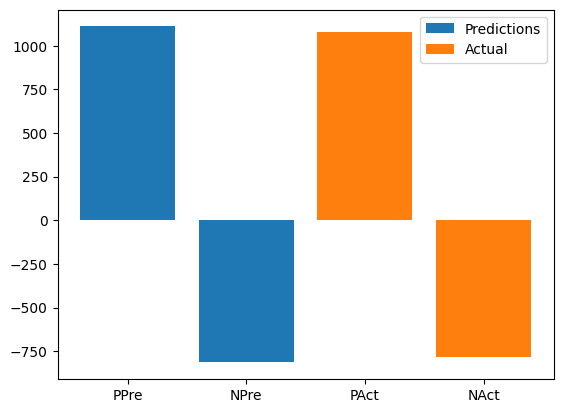

In [70]:
y_pred = y_pred_val
y_pred_pos = y_pred.sum()
y_pred_neg = len(y_pred) - y_pred_pos
y_test_pos = y_test.sum()
y_test_neg = len(y_test) - y_test_pos

plt.bar(["PPre", "NPre"], [y_pred_pos, y_pred_neg], label="Predictions")
plt.bar(["PAct", "NAct"], [y_test_pos, y_test_neg], label="Actual")

plt.legend()
plt.show()

Repeat question 5. However, this time do a logistic regression rather than a linear regression. To do a logistic regression, bin the reviews into `postive` and `negative` bins. Then predict the bin of the review.

I do both classify by the rating and also use the transformer pre-trained sentiment classification models to do the training.

In [71]:
# use LLM to judge whether it is positive or negative
# Convert the 'Rating' column into binary labels (positive or negative)
# # 1. Convert rating to binary sentiment
df['attitude'] = df['Rating'].apply(lambda x: 1 if x >= 3 else 0)

# 2. Define features and target
features = [
    "Cuisine", "Average Cost", "Open After 8pm?",
    "Marital Status", "Has Children?", "BMI",
    "Age", "Preferred Mode of Transport", "Northwestern Student?"
]
target = "attitude"

X = df[features]
y = df[target]

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 4. Define preprocessing
categorical = ["Cuisine", "Open After 8pm?", "Marital Status",
               "Has Children?", "Preferred Mode of Transport",
               "Northwestern Student?"]

numerical = ["Average Cost", "BMI", "Age"]

preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="most_frequent"), numerical),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

# 5. Build pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LogisticRegression(max_iter=1000, random_state=42))
])

# 6. Fit and predict
pipeline.fit(X_train, y_train)

y_proba = pipeline.predict_proba(X_test)  # shape: (n_samples, 2)
y_pred = pipeline.predict(X_test)
# 7. Evaluate
loss = log_loss(y_test, y_proba)  # y_test must be 0/1 integers
acc = accuracy_score(y_test, y_pred)
mse_logit = mean_squared_error(y_test, y_pred)

print(f"Cross-Entropy (Log Loss): {loss:.4f}")
print(f"Accuracy Score: {acc:.4f}")
print(f"mse is:{mse_logit:.4f}")


Cross-Entropy (Log Loss): 0.5584
Accuracy Score: 0.7405
mse is:0.2595


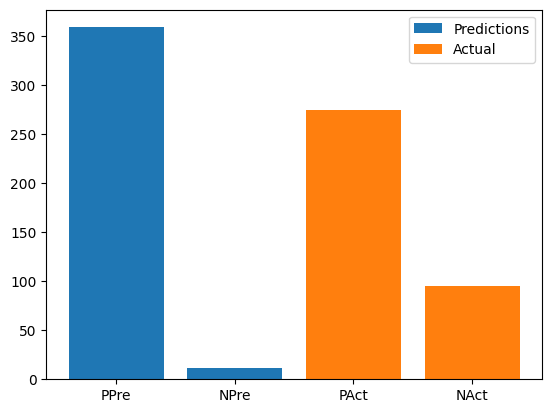

In [72]:
y_pred_pos = y_pred.sum()
y_pred_neg = len(y_pred) - y_pred_pos
y_test_pos = y_test.sum()
y_test_neg = len(y_test) - y_test_pos

plt.bar(["PPre", "NPre"], [y_pred_pos, y_pred_neg], label="Predictions")
plt.bar(["PAct", "NAct"], [y_test_pos, y_test_neg], label="Actual")

plt.legend()
plt.show()



Compare the performance of linear and logistic regression by creating a train/test split on your model? What is the error of your models? How should you compare them? Select a review from the test set and use your model to predict the restaurant score based on his user demographics and the restaurant's cuisine type. Compare the model's prediction with the actual score to assess its accuracy.

In [73]:
review = X_test.iloc[2]
print(review)
review_pred = pipeline.predict_proba(review.to_frame().T)
print(review_pred)
# should be positive because positive rate is greater than the negative rate.
true_rate = y_test.iloc[2]
print(true_rate)


Cuisine                         Chocolate
Average Cost                           20
Open After 8pm?                       Yes
Marital Status                    Married
Has Children?                         Yes
BMI                            111.328125
Age                                  82.0
Preferred Mode of Transport     Car Owner
Northwestern Student?                  No
Name: 1185, dtype: object
[[0.14428889 0.85571111]]
1


Pick your favorite model from step 7, either logistic regression of linear regression. Add an L1 penalty (Lasso regularization) into your regression model to observe its impact on the model's performance and feature selection. Compare the test-set results with the standard regression model developed in step 5 or 6. What features are selected by this L1 model? In other words, when are the weights of the linear model large? When are they small or negative? Are certain demographics more predictive of review score?

In [74]:
pipeline_l1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LogisticRegression(penalty='l1', max_iter=1000, solver = 'liblinear'))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# evaluation
model_l1 = pipeline_l1.fit(X_train, y_train)


y_proba_l1 = pipeline_l1.predict_proba(X_test)
y_pred_l1 = pipeline_l1.predict(X_test)

# Evaluation
loss_l1 = log_loss(y_test, y_proba_l1)
acc_l1 = accuracy_score(y_test, y_pred_l1)
mse_logit = mean_squared_error(y_test, y_pred_l1)
print("Cross-Entropy (Log Loss):", loss_l1)
print("Accuracy Score:", acc_l1)
print(mse_logit)


Cross-Entropy (Log Loss): 0.5557710171525193
Accuracy Score: 0.7378378378378379
0.26216216216216215


In [75]:
# Get feature names from the pipeline
feature_names = preprocessor.get_feature_names_out()
coefs = pipeline_l1.named_steps['regressor'].coef_.flatten()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'weight': coefs
}).sort_values(by='weight', key=abs, ascending=False)

# Selected features (non-zero weight)
selected_features = coef_df[coef_df['weight'] != 0].sort_values(by = 'weight', ascending=True)
selected_features


,feature,weight
8,cat__Cuisine_Burgers,-1.377980
24,cat__Cuisine_Seafood,-1.029906
3,cat__Cuisine_American,-0.961805
27,cat__Cuisine_Thai,-0.883318
16,cat__Cuisine_Italian,-0.846786
33,cat__Marital Status_Widow,-0.538649
20,cat__Cuisine_Mediterranean,-0.429417
19,cat__Cuisine_Korean,-0.231325
18,cat__Cuisine_Japanese,-0.218061
37,cat__Preferred Mode of Transport_On Foot,-0.189843


We want to know what demographic features are useful for predicting coffee scores. There are 3 coffee shops in the dataset. For these three restaurants only, write a linear model that takes demographic data and predicts the score.

In [76]:
coffee_shops = df[df['Cuisine'] == 'Coffee']
features = ["Average Cost", "Open After 8pm?",
    "Marital Status", "Has Children?", "Age", "BMI", "Preferred Mode of Transport", "Northwestern Student?"
]
target = "Rating"

X = coffee_shops[features]
y = coffee_shops[target]

# Define categorical and numerical features
categorical = ["Open After 8pm?", "Marital Status",
               "Has Children?", "Preferred Mode of Transport",
               "Northwestern Student?"]
numerical = ["Average Cost", "Age", "BMI",]

# Preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="most_frequent"), numerical),
    ("pf", OneHotEncoder(handle_unknown="ignore"), categorical)
])
print(preprocessor)
# Create model pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# predict
y_pred = pipeline.predict(X_test)
# Align X_test with the original coffee shop dataset 

X_test = X_test.copy() 
X_test['pred_rating'] = y_pred 

X_test_full = X_test.copy()
X_test_full['Restaurant Name'] = df.loc[X_test.index, 'Restaurant Name']

# Step 3: Group by restaurant and compute average predicted rating
coffee_shops_rating = X_test_full.groupby('Restaurant Name')['pred_rating'].mean()



ColumnTransformer(transformers=[('num', SimpleImputer(strategy='most_frequent'),
                                 ['Average Cost', 'Age', 'BMI']),
                                ('pf', OneHotEncoder(handle_unknown='ignore'),
                                 ['Open After 8pm?', 'Marital Status',
                                  'Has Children?',
                                  'Preferred Mode of Transport',
                                  'Northwestern Student?'])])


Examine the weights produced by the linear model developed in in step 9. Identify the demographic features that are most influential. In other words, when are the weights of the linear model large? When are they small or negative? Based on these weights, can we infer if certain demographic groups have a preference for or against coffee?

In [77]:
# weight means the coefficient
# Extract coefficients from the linear model
coefficients = pipeline.named_steps['regressor'].coef_
# Convert coefficients to a DataFrame for easier analysis
coffee_transformed = preprocessor.fit(coffee_shops)
num_features = preprocessor.transformers_[0][2]

# Get categorical column names after OneHotEncoder
cat_encoder = preprocessor.named_transformers_['pf']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

# Combine
all_features = np.concatenate([num_features, cat_features])
coefficients_df = pd.DataFrame(coefficients, index = all_features)
print(coefficients_df)


                                                   0
Average Cost                                0.000000
Age                                         0.008737
BMI                                         0.008517
Open After 8pm?_No                         -0.530405
Open After 8pm?_Yes                         0.530405
Marital Status_Married                      0.043391
Marital Status_Single                      -0.043391
Has Children?_No                            0.580021
Has Children?_Yes                          -0.580021
Preferred Mode of Transport_Car Owner       0.122219
Preferred Mode of Transport_On Foot        -0.757541
Preferred Mode of Transport_Public Transit  0.086567
Preferred Mode of Transport_nan             0.548755
Northwestern Student?_No                   -0.486769
Northwestern Student?_Yes                   0.486769


Text embedding:
Consider the column ``'Review Text'``. Embed the review texts into vectors using Sentence Transformers. Use these embeddings as features to train a logistic regression model to predict the review sentiment: positive or negative. Note, this repo contains reference code for embedding with sentence transformers. Compare the MSE of this model to the MSEs of the models in steps 5 and 7.

In [78]:
from sentence_transformers import SentenceTransformer
df['Review Text'] = df['Review Text'].fillna("")
model_name = 'all-MiniLM-L6-v2'
embedder = SentenceTransformer(model_name)

review_embeddings = embedder.encode(df['Review Text'].tolist(), show_progress_bar=True)

X = review_embeddings
y = df['attitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# to compare correctly with the logistic model which used the l1
model = LogisticRegression(penalty = 'l1', max_iter=1000, solver = 'saga')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
mse_2 = mean_squared_error(y_test, y_pred_proba)
accuracy_2 = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_2:.4f}")
print(f"MSE: {mse_2:.4f}")


Batches: 100%|██████████| 47/47 [00:00<00:00, 50.01it/s]


Accuracy: 0.8041
MSE: 0.1391


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# to compare correctly with the logistic model which used the l1
model = LogisticRegression(penalty = 'l1', max_iter=1000, solver = 'saga')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
mse_2 = mean_squared_error(y_test, y_pred_proba)
accuracy_2 = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_2:.4f}")
print(f"MSE: {mse_2:.4f}")

Accuracy: 0.8041
MSE: 0.1391


In [80]:
# trend for northwestern students
nu_students = df[df['Northwestern Student?']=='Yes']
mode_values = {
    'Cuisine': nu_students['Cuisine'].mode()[0],
    'Marital Status': nu_students['Marital Status'].mode()[0],
    'Has Children?': nu_students['Has Children?'].mode()[0],
    'Preferred Mode of Transport': nu_students['Preferred Mode of Transport'].mode()[0],
    'Open After 8pm?': nu_students['Open After 8pm?'].mode()[0],
    'Northwestern Student?': nu_students['Northwestern Student?'].mode()[0]
}
print(mode_values)
mode_values = {
    'Cuisine': df['Cuisine'].mode()[0],
    'Marital Status': df['Marital Status'].mode()[0],
    'Has Children?': df['Has Children?'].mode()[0],
    'Preferred Mode of Transport': df['Preferred Mode of Transport'].mode()[0],
    'Open After 8pm?': df['Open After 8pm?'].mode()[0],
    'Northwestern Student?': df['Northwestern Student?'].mode()[0]
}
print(mode_values)


{'Cuisine': 'Mexican', 'Marital Status': 'Single', 'Has Children?': 'No', 'Preferred Mode of Transport': 'On Foot', 'Open After 8pm?': 'Yes', 'Northwestern Student?': 'Yes'}
{'Cuisine': 'Japanese', 'Marital Status': 'Single', 'Has Children?': 'No', 'Preferred Mode of Transport': 'Car Owner', 'Open After 8pm?': 'Yes', 'Northwestern Student?': 'No'}


Final Results:
Find at least 1 interesting thing in the dataset and write about it. For example, find a single user that hates every restaurant they review, or a trend among Northwestern students. When I did this exercise, I found 18 interesting trends in the data with minimial effort. So there should be plenty of things to find.

Since the plot was added at last, so I directly used the results generated before and drew this plot.

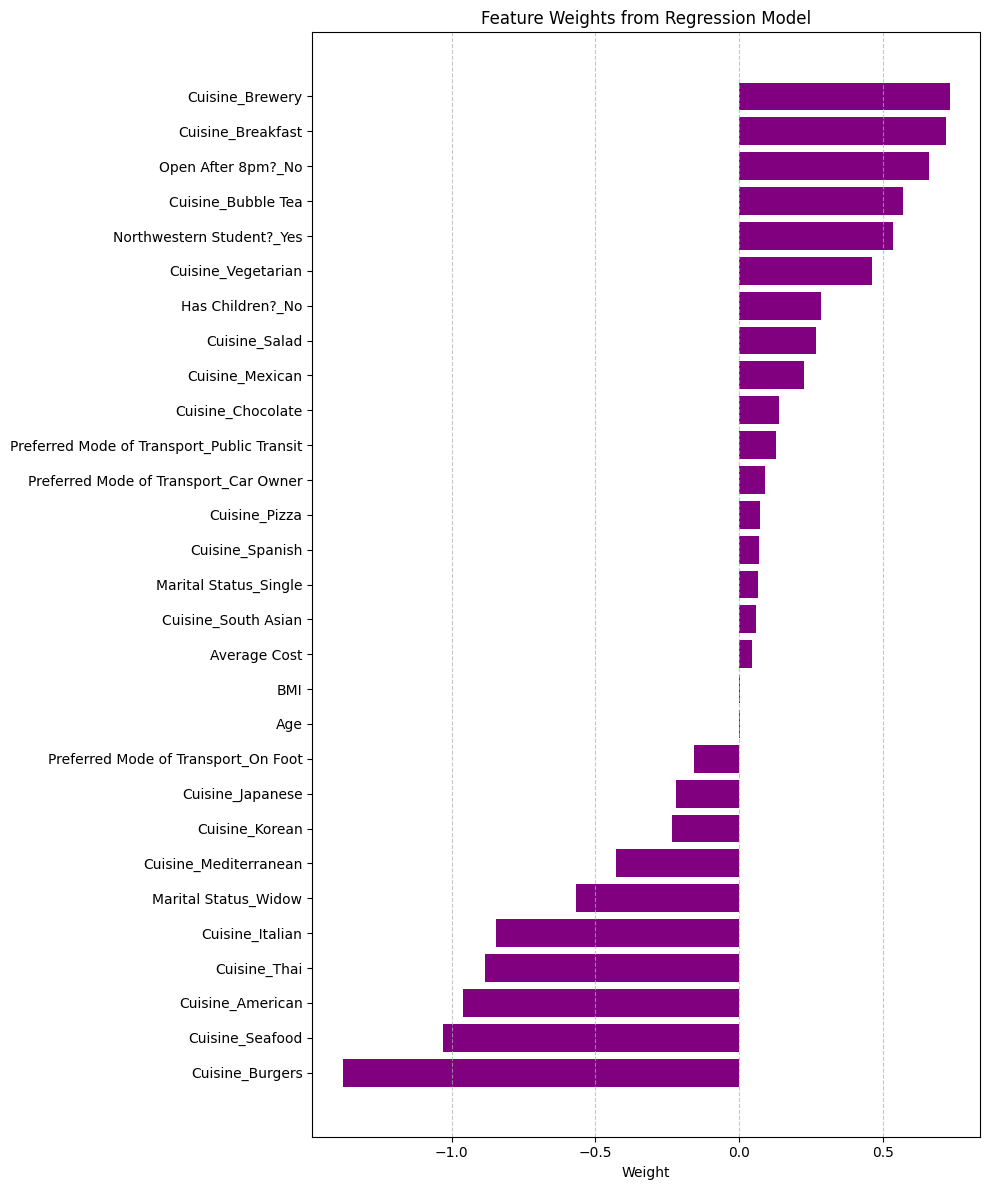

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
features = [
    "Cuisine_Burgers", "Cuisine_Seafood", "Cuisine_American", "Cuisine_Thai", "Cuisine_Italian",
    "Marital Status_Widow", "Cuisine_Mediterranean", "Cuisine_Korean", "Cuisine_Japanese",
    "Preferred Mode of Transport_On Foot", "Age", "BMI", "Average Cost", "Cuisine_South Asian",
    "Marital Status_Single", "Cuisine_Spanish", "Cuisine_Pizza", "Preferred Mode of Transport_Car Owner",
    "Preferred Mode of Transport_Public Transit", "Cuisine_Chocolate", "Cuisine_Mexican", "Cuisine_Salad",
    "Has Children?_No", "Cuisine_Vegetarian", "Northwestern Student?_Yes", "Cuisine_Bubble Tea",
    "Open After 8pm?_No", "Cuisine_Breakfast", "Cuisine_Brewery"
]

weights = [
    -1.379825, -1.028673, -0.962295, -0.884677, -0.847409,
    -0.567004, -0.429681, -0.232179, -0.219727, -0.155682,
     0.002593, 0.002866, 0.045222, 0.057750, 0.067353,
     0.069107, 0.072010, 0.090199, 0.129375, 0.138760,
     0.227989, 0.267828, 0.286672, 0.461732, 0.535825,
     0.570746, 0.662238, 0.718925, 0.733206
]

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Weight': weights}).sort_values(by='Weight')

# Plot
plt.figure(figsize=(10, 12))
plt.barh(df['Feature'], df['Weight'], color='purple')
plt.xlabel("Weight")
plt.title("Feature Weights from Regression Model")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
